In [25]:
import pandas as pd
import numpy as np
from env import api_key
import requests
import json
from acquire import *
from bs4 import BeautifulSoup
import os
from prepare import *
import matplotlib.pyplot as plt

# Acquire

In [2]:
# function calling the acquired df
links = get_links_to_bills()

In [3]:
df = acquire_bills(links, filename="adams_data.csv")

In [4]:
df

,sponsor,party,bill_text
0,"Plaskett, Stacey E.",D,<body><pre>\n[Congressional Bills 117th Congre...
1,"Pocan, Mark",D,<body><pre>\n[Congressional Bills 117th Congre...
2,"Pocan, Mark",D,<body><pre>\n[Congressional Bills 117th Congre...
3,"Reschenthaler, Guy",R,<body><pre>\n[Congressional Bills 117th Congre...
4,"Rush, Bobby L.",D,<body><pre>\n[Congressional Bills 117th Congre...
...,...,...,...
6439,"Norton, Eleanor Holmes",D,<body><pre>\n[Congressional Bills 117th Congre...
6440,"Nunes, Devin",R,<body><pre>\n[Congressional Bills 117th Congre...
6441,"Payne, Donald M., Jr.",D,<body><pre>\n[Congressional Bills 117th Congre...
6442,"Ruiz, Raul",D,<body><pre>\n[Congressional Bills 117th Congre...


# Prepare

In [5]:
bills_df = prep_bills(df)
bills_df

,sponsor,party,bill_text
0,"Plaskett, Stacey E.",D,<body><pre>\n[Congressional Bills 117th Congre...
1,"Pocan, Mark",D,<body><pre>\n[Congressional Bills 117th Congre...
3,"Reschenthaler, Guy",R,<body><pre>\n[Congressional Bills 117th Congre...
4,"Rush, Bobby L.",D,<body><pre>\n[Congressional Bills 117th Congre...
5,"Schneider, Bradley Scott",D,<body><pre>\n[Congressional Bills 117th Congre...
...,...,...,...
6434,"Lieu, Ted",D,<body><pre>\n[Congressional Bills 117th Congre...
6435,"McKinley, David B.",R,<body><pre>\n[Congressional Bills 117th Congre...
6438,"Miller-Meeks, Mariannette",R,<body><pre>\n[Congressional Bills 117th Congre...
6440,"Nunes, Devin",R,<body><pre>\n[Congressional Bills 117th Congre...


In [6]:
# creating a lemmatized column and cleaning the df
bills_df['lem']= bills_df.bill_text.apply(clean_text)

/var/folders/2g/_40bymd11_x47n42bls8ypmr0000gn/T/ipykernel_33849/3072378743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bills_df['lem']= bills_df.bill_text.apply(clean_text)


In [7]:
bills_df['model']= bills_df.lem.apply(join)
bills_df.head()

/var/folders/2g/_40bymd11_x47n42bls8ypmr0000gn/T/ipykernel_33849/1534073813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bills_df['model']= bills_df.lem.apply(join)


,sponsor,party,bill_text,lem,model
0,"Plaskett, Stacey E.",D,<body><pre>\n[Congressional Bills 117th Congre...,"[bodypre, congressional, bill, 117th, congress...",bodypre congressional bill 117th congress u go...
1,"Pocan, Mark",D,<body><pre>\n[Congressional Bills 117th Congre...,"[bodypre, congressional, bill, 117th, congress...",bodypre congressional bill 117th congress u go...
3,"Reschenthaler, Guy",R,<body><pre>\n[Congressional Bills 117th Congre...,"[bodypre, congressional, bill, 117th, congress...",bodypre congressional bill 117th congress u go...
4,"Rush, Bobby L.",D,<body><pre>\n[Congressional Bills 117th Congre...,"[bodypre, congressional, bill, 117th, congress...",bodypre congressional bill 117th congress u go...
5,"Schneider, Bradley Scott",D,<body><pre>\n[Congressional Bills 117th Congre...,"[bodypre, congressional, bill, 117th, congress...",bodypre congressional bill 117th congress u go...


In [8]:
# splitting the data
train, X_train, y_train, X_val, y_val, X_test, y_test = split_data(bills_df, 'model')

In [9]:
train.shape

(2936, 5)

In [16]:
def word_freq_new_df(df, clean_text):
    '''
    This function takes in a dataframe and the clean_text function
    to produce a new dataframe of words and word frequency rates.
    '''
    # creating a list of words for bill text and political parties
    all_bill_words = clean_text(' '.join(df['bill_text']))
    democrat_words = clean_text(' '.join(df[df['party'] == 'D']['bill_text']))
    republican_words = clean_text(' '.join(df[df['party'] == 'R']['bill_text']))
    ind_words = clean_text(' '.join(df[df['party'] == 'I']['bill_text']))
    # The value counts for the bill_text and political party words
    bill_counts = pd.Series(all_bill_words).value_counts()
    democrat_counts = pd.Series(democrat_words).value_counts()
    republican_counts = pd.Series(republican_words).value_counts()
    ind_counts = pd.Series(ind_words).value_counts()
    # concatinating the bill_text and political parties into one dataframe
    word_freq = pd.concat([bill_counts, democrat_counts, republican_counts, ind_counts], axis=1)
    word_freq.columns = ['bills', 'demo', 'repub', 'ind']
    # eliminating the most and least frequent words to reveal a more accurate depiction of specific political
    # parties and their respective top words
    word_freq = word_freq.loc[word_freq['bills'] <= 200]
    word_freq = word_freq.loc[word_freq['bills'] >= 25]
    # filling the nan values with zero and making the df columns integers versus floats
    word_freq.fillna(0, inplace=True)
    word_freq = word_freq.astype('int')
    return word_freq

In [17]:
# creating word_freq df
word_freq = word_freq_new_df(train, clean_text)

In [19]:
word_freq.shape

(6139, 4)

In [18]:
word_freq.head(50)

,bills,demo,repub,ind
alleged,200,165,35,0
connected,200,142,55,3
municipal,200,176,23,1
1985,200,127,73,0
claimant,200,149,51,0
side,200,122,78,0
accredited,200,177,23,0
concurrent,200,144,53,3
deputy,200,167,33,0
round,199,129,70,0


In [22]:
def demo_vis(word_freq):
    '''
    This function creates a bar plot of the most common words appearing for democrats.
    '''
    
    #Plot the most frequent democratic words and color by label
    word_freq.sort_values('demo', ascending=False).head(5).plot.bar(figsize=(16, 9))
    plt.title('Most Common Words for Democrats')
    plt.ylabel('Count')
    plt.xlabel('Most Common Words')
    plt.xticks(rotation=45)
    return plt.show()

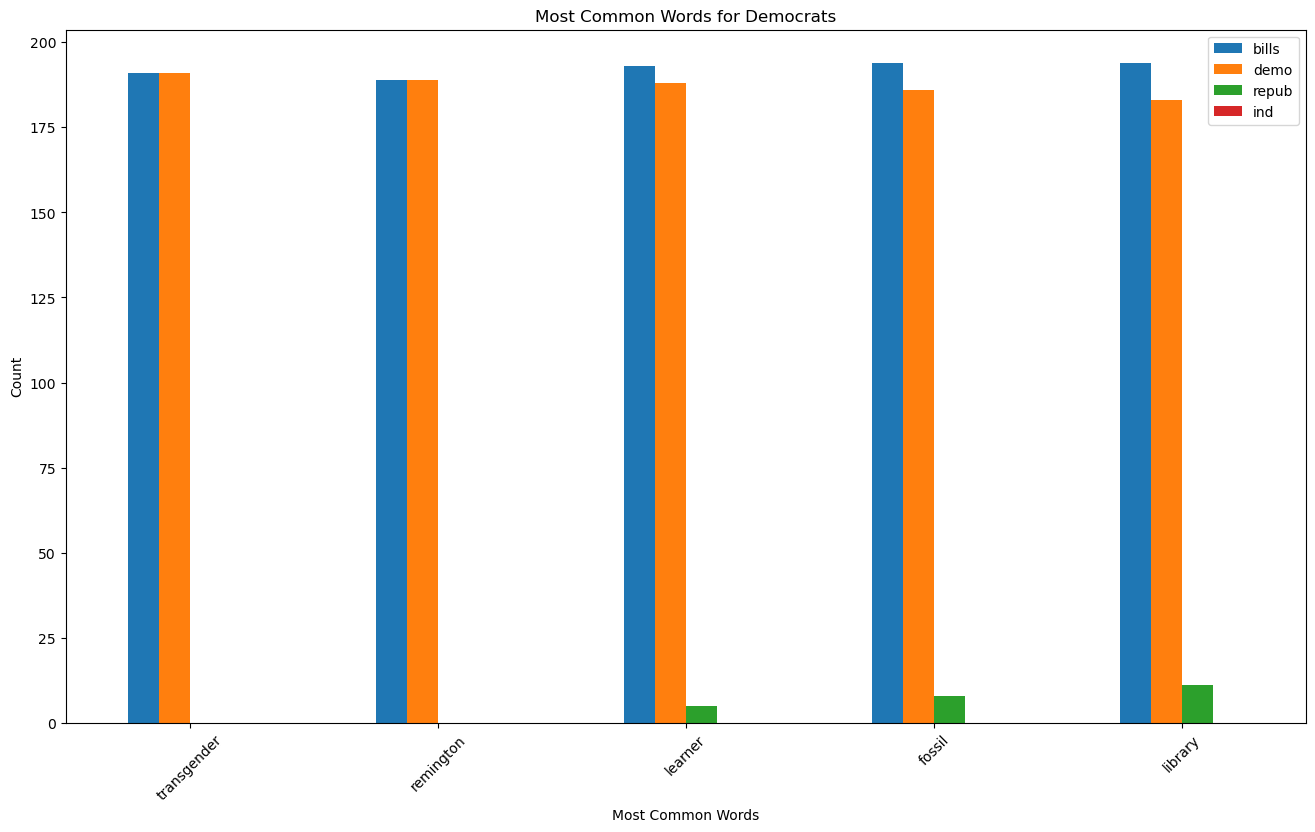

In [26]:
democrat = demo_vis(word_freq)

In [27]:
def repub_vis(word_freq):
    '''
    This function creates a bar plot of the most common words appearing for republicans.
    '''
    
    #Plot the most frequent democratic words and color by label
    word_freq.sort_values('repub', ascending=False).head(5).plot.bar(figsize=(16, 9))
    plt.title('Most Common Words for Republicans')
    plt.ylabel('Count')
    plt.xlabel('Most Common Words')
    plt.xticks(rotation=45)
    return plt.show()

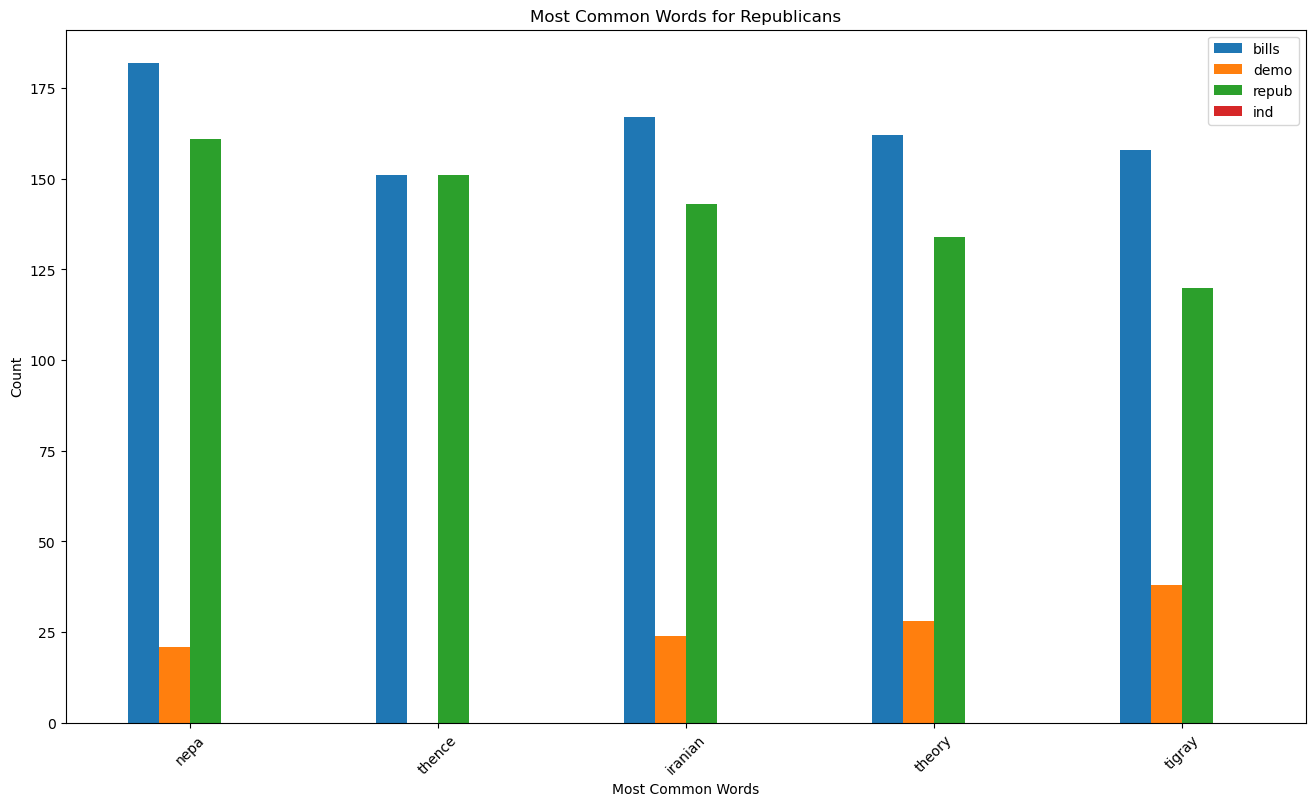

In [28]:
republican = repub_vis(word_freq)